# The Lensing Posterior

Much of what the CMBLensing package does is centered on the "CMB lensing posterior". We refer to either the "**joint posterior**", 

$$ \mathcal{P}(f,\phi,\theta\,|\,d), $$

where

* $f$ are the CMB fields (T/Q/U)
* $\phi$ is the lensing potential
* $\theta$ are any cosmological parameters
* $d$ is the data,

or the "**marginal posterior**", 

$$ \mathcal{P}(\phi,\theta\,|\,d) \equiv \int \! \mathcal{D}f \; \mathcal{P}(f,\phi,\theta\,|\,d), $$

which is simply the joint posterior marginalized over $f$. 

We assume the following data model, which is generally flexible enough to handle real experiments:

$$ d = \mathbb{P} \, \mathbb{M} \, \mathbb{B} \, \mathbb{L}(\phi) \, f + n, $$

where 

* $\mathbb{L}(\phi)$ is the lensing operation
* $\mathbb{B}$ is an instrumental transfer function or "beam"
* $\mathbb{M}$ is a user-chosen mask
* $\mathbb{P}$ is a pixelization operation which allows one to estimate $f$ on a higher resolution than the data
* $n$ is the instrumental noise. 


Given this model, the joint posterior (up to an unimportant normalization constant) in the "**unlensed parameterization**", is:

$$ 
-2\ln\mathcal{P}(f,\phi,\theta\,|\,d) = \frac{\big(d - \mathbb{P} \, \mathbb{M} \, \mathbb{B} \, \mathbb{L}(\phi) \, f\big)^2}{\mathbb{C}_n}
+ \frac{f^2}{\mathbb{C}_f(\theta)} + \frac{\phi^2}{C_\phi(\theta)} + \log\det \mathbb{C}_f(\theta) + \log\det C_\phi(\theta),
$$

where

* $\mathbb{C}_n$ is the noise covariance
* $\mathbb{C}_f$ is the CMB covariance (i.e. the CMB T, E, and B $C_\ell$'s)
* $\mathbb{C}_\phi$ is the lensing potential covariance (i.e. $C_\ell^{\phi\phi}$)

and we have used the slighly sloppy notation $x^2/\mathbb{C}$ to mean $x^\dagger \mathbb{C}^{-1} x$.

It's often useful to parameterize this in terms of the lensed $\tilde f = \mathbb{L}(\phi) f$ (this reduces correlations), in which case we have the ""**lensed parametrization**":

$$ 
-2\ln\mathcal{P}(\tilde f,\phi,\theta\,|\,d) = \frac{\big(d - \mathbb{P} \, \mathbb{M} \, \mathbb{B} \, \tilde f\big)^2}{\mathbb{C}_n}
+ \frac{\big(\mathbb{L}(\phi)^{-1} \tilde f\big)^2}{\mathbb{C}_f(\theta)} + \frac{\phi^2}{C_\phi(\theta)} + \log\det \mathbb{C}_f(\theta) + \log\det C_\phi(\theta),
$$

## Posterior basics

In [54]:
using CMBLensing
using PyPlot

CMBLensing uses the function `lnP` to compute the log of the joint posterior probability. 

To evaluate this posterior, we need the arguments of the probability distribution, $f$, $\phi$, and $\theta$. We also need the data $d$ and host of other operators and covariances which enter the expressions above, which CMBLensing stores in a `DataSet` object.

First lets load up some simulated data. We'll use 1$\mu$K-arcmin noise and a border mask:

In [55]:
@unpack f, ϕ, ds, L = load_sim_dataset(
    θpix      = 2,
    Nside     = 256,
    T         = Float64,
    use       = :P,
    μKarcminT = 1,
    L         = LenseFlow{RK4Solver{10}},
    seed      = 0,
    pixel_mask_kwargs = (edge_padding_deg=1, apodization_deg=0, num_ptsrcs=0),
    bandpass_mask     = LowPass(5000)
);

The `DataSet` object, `ds`, stores all the aforementioned quantities:

In [56]:
fieldnames(typeof(ds))

(:d, :Cϕ, :Cf, :Cf̃, :Cn, :Cn̂, :M, :M̂, :B, :B̂, :D, :G, :P, :L)

For example, the data is:

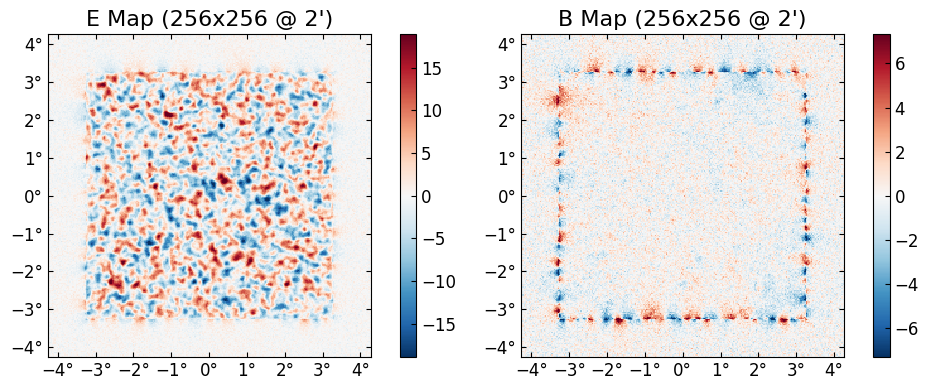

In [57]:
plot(ds.d);

We can now evaluate the posterior, for example at the true $f$ and $\phi$:

In [58]:
-2*lnP(0, f, ϕ, ds)

307989.9304561836

The first argument, `0`, indicates that this is in the unlensed parameterization. We could also use `1` for the lensed parametriation. (The `0` and `1` refer to auxillary "time" variable in the LenseFlow expansion, $f(x+t\nabla\phi)$; at $t=0$ we have the unlensed field, and at $t=1$ we have the lensed field). If we use the lensed parametrization, then the $f$ argument to the function is expected to be the lensed field.

In [59]:
-2*lnP(1, L(ϕ)*f, ϕ, ds)

307989.8639035257

We expect minus twice the posterior evaluated at the truth to be distributed like a $\chi^2$ distribution where the degrees of freedom equals the number of pixels in $d$, $f$, and $\phi$ (i.e. in each of the three Gaussian terms in the posterior). Since these maps are 256x256 and $d$ and $f$ have both Q and U maps, this is:

In [60]:
(2+2+1)*256^2

327680

which the previous result is within a few sigma of.

Above, we didn't specify any cosmological parameters, $\theta$. Because of that, they were fixed at their fiducial values (i.e. the fiducial values which generated the simulated data in the call to `load_sim_dataset` earlier). Current only two parameters can be varied, $r$ (tensor-to-scalar ratio), and $A_\phi$ (the amplitude of $C_\ell^{\phi \phi}$). They can be specified as follows, with non-specified parameters left at their fiducial:

In [61]:
-2*lnP(0, f, ϕ, (Aϕ=1.1,), ds)

308226.8865766122

You can see the slight change compared to what we got above. We can even compute a whole slice through the posterior along $A_\phi$:

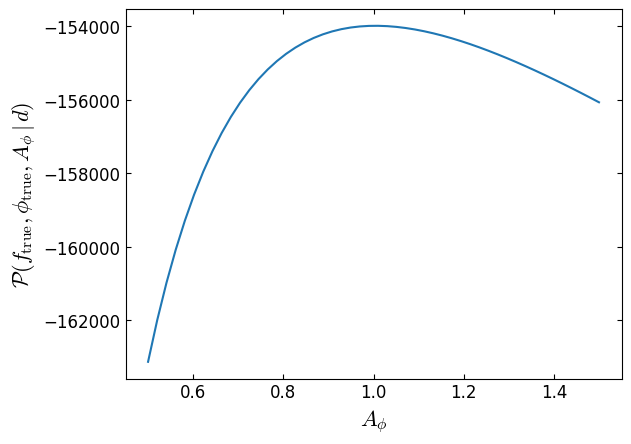

In [62]:
Aϕs = range(0.5,1.5,length=50)
plot(Aϕs, [lnP(0, f, ϕ, (Aϕ=Aϕ,), ds) for Aϕ in Aϕs])
xlabel(raw"$A_\phi$")
ylabel(raw"$\mathcal{P}(f_{\rm true}, \phi_{\rm true}, A_\phi\,|\,d)$");

## Wiener filtering

If we fix $\phi$ and $\theta$ then maximize the joint posterior, $\mathcal{P}(f,\phi,\theta\,|\,d)$, over $f$, we get

$$
\hat f_{\rm wf} = \big[ \mathbb{C}_f(\theta)^{-1} + \mathbb{A}^\dagger\mathbb{C}_n^{-1}\mathbb{A} \big]^{-1} \mathbb{A}^\dagger\mathbb{C}_n^{-1}d
$$

where

$$
\mathbb{A} = \mathbb{M} \, \mathbb{P}\,  \mathbb{B} \, \mathbb{L}(\phi)
$$

This is simply the Wiener filter of the data, and we can compute it by inverting the operator in brackets above with e.g. Conjugate Gradient. 

In CMBLensing, the `argmaxf_lnP` function performs this task. Its arguments are similar to `lnP`,

In [63]:
f_wf = argmaxf_lnP(ϕ, (Aϕ=1,), ds, tol=1e-1, progress=true);

Conjugate Gradient: 100%|███████████████████████████████| Time: 0:00:22


Since Wiener filtering is the best-fit of the joint posterior at a fixed $\phi$, it is effectively delensing the data by a given $\phi$. Here we are Wiener filtering at the true $\phi$, so this is perfect delensing. 

Note below the large amount of B mode power in the data, as well as the aliasing near the border mask, and how this is removed in the Wiener filtered B, which visually is tracing the true B map up to the level of the noise.

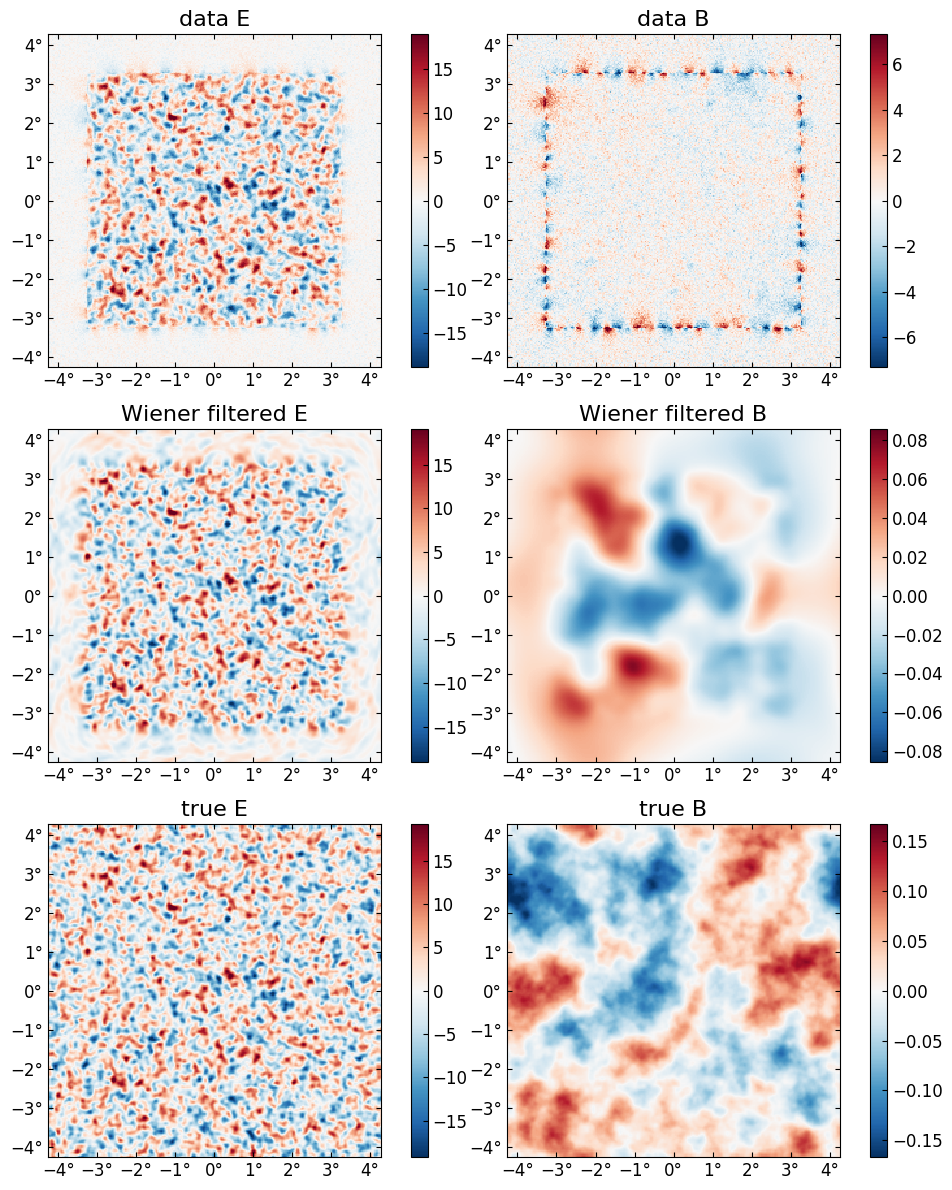

In [64]:
plot([ds.d, f_wf, f], title=["data ", "Wiener filtered ", "true "] .* ["E" "B"]);

## Posterior gradients

## Marginal posterior